In [27]:
import os

cuda_device = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
# os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm, trange

import random

from tensorboardX import SummaryWriter

from scipy import integrate

sns.set_style("white")
torch.cuda.is_available()

from statistics import geometric_mean


# parameters

In [28]:
# hyperparameters
tau_train = 0.01
gamma = 0.99999

h_test = 0.01
tau_test = 0.005

coe_loss = 0.0001
coe_structure = 0.00001
coe_data = 1.0
coe_regular = 0.001

coe_R = 0.1

Adam_proportion = 0.95
batch_size_LBFGS = 32

# to find the least minimum to be averaged
num_least = 3

# parameters of the Burger's equation
nu = 0.01 / math.pi

# the initial condition
def IC(x):
    # return -torch.sin(math.pi * x)
    return 2 * math.pi * nu * (torch.sin(math.pi * x)) / (2 + torch.cos(math.pi * x))

def exact_solution(X):
    x = X[:,0]
    t = X[:,1]
    
    return 2 * math.pi * nu * (torch.exp(- math.pi**2 * nu * t) * torch.sin(math.pi * x)) / (2 + torch.exp(- math.pi**2 * nu * t) * torch.cos(math.pi * x))

# spatial domain
x0 = -1.0
x1 = 1.0

# temporal domain
t0 = 0.0
t1 = 1.0

coe_without_R = 0.8
coe_without_R_abs = 0.25
coe_without_R_new = 0.0

coe_without_R_reg = 0.0
width_R_reg = 4
coe_regular = 0.00001

criterion = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


num_processes = 5

# param_vector = [16, 32, 64, 128]
# param_vector = [3, 5, 10, 40]
# param_vector = [2, 4, 8, 16, 32]
# param_vector = [2, 4, 8, 16, 32, 64]
param_vector = [32]
# param_vector = [4, 8, 16, 32, 64, 128, 256]
num_hidden = 1
width_R = 10
width_R_abs = 4
num_hidden_R = 1

width_R_LBFGS = 10

num_divide = 0

# param_vector = [1, 2, 4, 6, 8, 10, 12, 14, 16, 32, 64, 128]

In [29]:
def setup_seed(seed):
    
    random.seed(seed)   # Python的随机性
    os.environ['PYTHONHASHSEED'] = str(seed)    # 设置Python哈希种子，为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)   # numpy的随机性
    torch.manual_seed(seed)   # torch的CPU随机性，为CPU设置随机种子
    torch.cuda.manual_seed(seed)   # torch的GPU随机性，为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.   torch的GPU随机性，为所有GPU设置随机种子
    torch.backends.cudnn.benchmark = False   # if benchmark=True, deterministic will be False
    torch.backends.cudnn.deterministic = True

    
# the whole network is divide into two parts    

# the subnetwork followed the standard PINNs to get the solution v of the PDE 
class PDE_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(PDE_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out
    
    
# the subnetwork related to the structure factor R (conservative or dissipative)    
class structure_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 1,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(structure_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size, bias = True)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)
        

    def forward(self, t):
        out = self.layers(t) 
        return out
    
    
# the whole network with a output as u = R * v
# to add the regularization term, we have to give the two output separately
class NN_sidecar(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_sidecar, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)
        self.structure = structure_NN(width_R, num_hidden_R)

    def forward(self, X):
        v = self.PDE(X)
        R = self.structure(X[:,1].reshape(-1, 1))
#         print(torch.size(X[:,1]))
        return v, R
    

class NN(nn.Module):
    def __init__(self, width, num_hidden):
        super(NN, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)
        # self.structure = structure_NN()

    def forward(self, X):
        v = self.PDE(X)
#         R = self.structure(X[:,1].reshape(-1, 1))
# #         print(torch.size(X[:,1]))
#         return v, R
        # u = self.PDE(X)
        return v

# model.load_state_dict(torch.load(f"1DBurgers-Original-bs{batch_size}-epoches{epoches}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}.pth"))

In [30]:
class PDE_NN_2(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN_2, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out
    
    
# the whole network with a output as u = R * v
# to add the regularization term, we have to give the two output separately
class NN_onebig(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_onebig, self).__init__()
        self.PDE = PDE_NN_2(width, num_hidden)
        # self.structure = structure_NN(width_R, num_hidden_R)

    def forward(self, X):
        u = self.PDE(X)
        # R = self.structure(X[:,1].reshape(-1, 1))
#         print(torch.size(X[:,1]))
        
        v, R = torch.unbind(u, dim=1)
        return v.reshape(-1, 1), R.reshape(-1, 1)

In [31]:
def loss_fn_PINN(u_pred_bic, u_bic, u_pred, X, x, t, epoch):
    
        # the final output of the network    
        # u_pred_bic = v_pred_bic * R_bic
        # u_pred = v_pred * R


        ####### 1. the bc and ic error
        loss_data = criterion(u_pred_bic, u_bic)

        
####### 2. PDE error       
        # the derivative 
        du_dX = torch.autograd.grad(
                inputs = X, 
                outputs = u_pred, 
                grad_outputs = torch.ones_like(u_pred), 
                retain_graph = True, 
                create_graph = True
            )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
                inputs = X, 
                outputs = du_dx, 
                grad_outputs = torch.ones_like(du_dx), 
                retain_graph = True, 
                create_graph = True
            )[0][:, 0]

        # the L^2 norm of the PDE residual
        loss_pde = criterion(du_dt + u_pred.squeeze() * du_dx, nu * du_dxx)
        

# ####### 3. structure error
#         


####### 4. energy error
        # the energy dissipation compared with the exact solution
        # d/dt \int_-1^1 u^2 dx = -2 nu int_-1^1 u_x^2 dx
        # which gives \int_-1^1 u^2 dx |_0^T = \int_0^T -2 nu int_-1^1 u_x^2 dx dt

        # u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # try to integrate each part
        # x_half = int(len(x_test) / 2)

        # to find the position of shock wave
        # # way 1: find the minimum function value 

        # # avoid the boundary
        # x_third = int(len(x) / 3)

        # x_shock = np.where(np.abs(u_pred_matrix[x_third:2*x_third, -1]) 
        #                 == np.min(np.abs(u_pred_matrix[x_third:2*x_third, -1])))[0].item() + x_third
        # print(x_shock)

        # way 2: find the maximum gradient value
        # x_shock = np.where(np.abs(du_dx_matrix[:, -1]) == np.max(np.abs(du_dx_matrix[:, -1])))[0].item()
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))
        # print(x_shock)

        u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()


        loss_energy = np.max(np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy())))

        # RHS = -2 * nu * (integrate.simpson(du_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(du_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy()))
        # # RHS = -2 * nu * integrate.simpson(du_dx_matrix.T ** 2, x_test.cpu().numpy())


        # temp_integral = integrate.simpson(u_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(u_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())
        # # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x_test.cpu().numpy()).squeeze()
        # LHS = np.gradient(temp_integral, t.cpu().numpy())

        # loss_energy = np.max(np.abs(LHS - RHS))

        # to measure the postion error of shock waves
        loss_shock_position = np.abs(x[x_shock] - x[int(len(x) / 2)])


        loss_exact = criterion(exact_solution(X), u_pred.squeeze())


        # du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        # RHS = -2 * nu * integrate.simpson(integrate.simpson(du_dx_matrix.T ** 2, x.cpu().numpy()), t.cpu().numpy())


        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()
        # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x.cpu().numpy()).squeeze()
        # LHS = integral_temp[-1] - integral_temp[0]


        # loss_energy = np.abs(LHS - RHS)


        # loss_energy = np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy()))



####### 5. regularization error
        
        # loss_regular = self.criterion(R, torch.ones(R.size()).to(self.device))


        # total error

        # # To ensure that the PDE network can learn enough things to guide the R
        # if epoch < self.coe_without_R * self.epoches:
        #     loss = loss_pde + loss_data
        #     # print(f"without R{epoch}")
        # else:
        #     loss = loss_pde + loss_data + loss_structure

        # loss = loss_pde + loss_data + loss_regular + loss_structure
        
        loss = loss_pde + loss_data

        return loss, loss_pde, loss_data, loss_energy, loss_exact

In [32]:
def loss_fn_sidecar_abs(v_pred_bic, R_bic, u_bic, v_pred, R, X, x, t, epoch):
    
        u_pred_bic = v_pred_bic * R_bic
        u_pred = v_pred * R
        
        
####### 1. the bc and ic error
        loss_data = criterion(u_pred_bic, u_bic)

        
####### 2. PDE error       
        # the derivative 
        du_dX = torch.autograd.grad(
                inputs = X, 
                outputs = u_pred, 
                grad_outputs = torch.ones_like(u_pred), 
                retain_graph = True, 
                create_graph = True
            )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
                inputs = X, 
                outputs = du_dx, 
                grad_outputs = torch.ones_like(du_dx), 
                retain_graph = True, 
                create_graph = True
            )[0][:, 0]

        # the L^2 norm of the PDE residual
        loss_pde = criterion(du_dt + u_pred.squeeze() * du_dx, nu * du_dxx)
        

####### 3. structure error
        # the Burgers function satisfies the dissipative law as 
        # d/dt \int u^2 dx = -2 \nu \int u_x^2 dx
        
        # x_temp = torch.arange(-1, 1, self.h)

        # v_pred_matrix = v_pred.reshape(len(x_temp), len(t)).cpu().numpy()

        # find the shock to divide the integral
        du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))

        v_pred_matrix = v_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # theta_1 = integrate.simpson(v_pred_matrix.T ** 2, x.cpu().numpy())
        theta_1 = integrate.simpson(v_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(v_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())

        # print(np.shape(theta_1[:2]))
        
        dv_dX = torch.autograd.grad(
                inputs = X, 
                outputs = v_pred, 
                grad_outputs = torch.ones_like(v_pred), 
                retain_graph = True, 
                # create_graph = True
            )[0]
        
        dv_dx_matrix = dv_dX[:, 0].reshape(len(x), len(t)).detach().cpu().numpy()
        
        # print(f"dv_dx_matrix.T ** 2: ", np.shape(dv_dx_matrix.T ** 2))
        # print(f"self.x.cpu().numpy(): ", np.shape(self.x.cpu().numpy()))

        # theta_2 = integrate.simpson(dv_dx_matrix.T ** 2, x.cpu().numpy())
        theta_2 = integrate.simpson(dv_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(dv_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())

        # try a new R_0 setting
        # R_0 = \int IC(x)/v(x, 0) dx
        # or we try R_0 = \int |IC(x) / v(x, 0)| dx

        # ideal IC f(x) = IC(x)
        f = IC(x).cpu().numpy()

        # to avoid the denominator to be zero
        # create a mask to find the position of zero
        zero_denominator_mask = (v_pred_matrix[:,0] == 0)

        # replace the zero with 1 in the denominator
        R_0_temp = f / np.where(zero_denominator_mask, np.ones_like(v_pred_matrix[:,0]), v_pred_matrix[:,0])

        # reset the result of the zero position to 1
        R_0_temp[zero_denominator_mask] = 1

        # R_0_temp = f.squeeze() / v_pred_matrix[:,0]

        R_0 = np.abs(integrate.simpson(R_0_temp[:x_shock+1], x[:x_shock+1].cpu().numpy()) + integrate.simpson(R_0_temp[x_shock:], x[x_shock:].cpu().numpy())) / 2.0

        R_ture_temp = np.ones(len(t))

        R_ture_temp[0] = R_0

        for i in range(1, len(t)):
            # print(f"theta_2[:i] / theta_1[:i]: ", np.shape((theta_2[:i] / theta_1[:i]).reshape(-1,1).T))
            # print(f"self.t[:i]: ", np.shape(self.t[:i].cpu().numpy()))
            
            temp_integral = integrate.simpson((theta_2[:i+1] / theta_1[:i+1]).reshape(-1,1).T, t[:i+1].cpu().numpy()).item()            

            R_ture_temp[i] = np.sqrt(R_0**2 * theta_1[0] / theta_1[i] * np.exp(-2 * nu * temp_integral))

        # loss_R = torch.nn.L1Loss()

        # to match the size of the given R
        R_ture = torch.from_numpy(R_ture_temp).to(device).repeat(int(len(R) / len(R_ture_temp))).reshape(-1,1).to(torch.float32)


        # loss_structure = loss_R(R, R_square_ture)
        loss_structure = criterion(R, R_ture)


####### 4. energy error
        # the energy dissipation compared with the exact solution
        # d/dt \int_-1^1 u^2 dx = -2 nu int_-1^1 u_x^2 dx
        # which gives \int_-1^1 u^2 dx |_0^T = \int_0^T -2 nu int_-1^1 u_x^2 dx dt

        # u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        
        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # try to integrate each part
        # x_half = int(len(x_test) / 2)

        # to find the position of shock wave
        # # way 1: find the minimum function value 

        # # avoid the boundary
        # x_third = int(len(x) / 3)

        # x_shock = np.where(np.abs(u_pred_matrix[x_third:2*x_third, -1]) 
        #                 == np.min(np.abs(u_pred_matrix[x_third:2*x_third, -1])))[0].item() + x_third
        # print(x_shock)

        # way 2: find the maximum gradient value
        # x_shock = np.where(np.abs(du_dx_matrix[:, -1]) == np.max(np.abs(du_dx_matrix[:, -1])))[0].item()
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))
        # print(x_shock)

        u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()


        loss_energy = np.max(np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy())))

        # RHS = -2 * self.nu * (integrate.simpson(du_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(du_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy()))
        # # RHS = -2 * nu * integrate.simpson(du_dx_matrix.T ** 2, x_test.cpu().numpy())


        # temp_integral = integrate.simpson(u_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(u_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())
        # # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x_test.cpu().numpy()).squeeze()
        # LHS = np.gradient(temp_integral, t.cpu().numpy())

        # loss_energy = np.max(np.abs(LHS - RHS))

        # to measure the postion error of shock waves
        loss_shock_position = np.abs(x[x_shock] - x[int(len(x) / 2)])

        # du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        # RHS = -2 * nu * integrate.simpson(integrate.simpson(du_dx_matrix.T ** 2, x.cpu().numpy()), t.cpu().numpy())


        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()
        # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x.cpu().numpy()).squeeze()
        # LHS = integral_temp[-1] - integral_temp[0]


        # loss_energy = np.abs(LHS - RHS)


        # loss_energy = np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy()))



####### 5. regularization error
        
        loss_exact = criterion(exact_solution(X), u_pred.squeeze())


        # total error

        # To ensure that the PDE network can learn enough things to guide the R
        if epoch < coe_without_R * epoches:
            loss = loss_pde + coe_data * loss_data
            # print(f"without R{epoch}")
        else:
            loss = loss_pde + coe_data * loss_data + coe_loss * loss_structure

        # loss = loss_pde + loss_data + loss_regular + loss_structure
        
        # loss = loss_pde + loss_data

        return loss, loss_pde, loss_data, loss_exact, loss_structure, loss_energy, loss_shock_position

In [33]:
def loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X, x, t, epoch):
    
        # if epoch < self.coe_without_R * self.epoches:
        #     u_pred_bic = v_pred_bic
        #     u_pred = v_pred
        # else:
        #     u_pred_bic = v_pred_bic * R_bic
        #     u_pred = v_pred * R
        
        # the final output of the network    
        u_pred_bic = v_pred_bic * R_bic
        u_pred = v_pred * R
        
        
####### 1. the bc and ic error
        loss_data = criterion(u_pred_bic, u_bic)

        
####### 2. PDE error       
        # the derivative 
        du_dX = torch.autograd.grad(
                inputs = X, 
                outputs = u_pred, 
                grad_outputs = torch.ones_like(u_pred), 
                retain_graph = True, 
                create_graph = True
            )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
                inputs = X, 
                outputs = du_dx, 
                grad_outputs = torch.ones_like(du_dx), 
                retain_graph = True, 
                create_graph = True
            )[0][:, 0]

        # the L^2 norm of the PDE residual
        loss_pde = criterion(du_dt + u_pred.squeeze() * du_dx, nu * du_dxx)
        

####### 3. structure error
        # the Burgers function satisfies the dissipative law as 
        # d/dt \int u^2 dx = -2 \nu \int u_x^2 dx
        
        # x_temp = torch.arange(-1, 1, self.h)

        # v_pred_matrix = v_pred.reshape(len(x_temp), len(t)).cpu().numpy()

        # find the shock to divide the integral
        du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))

        v_pred_matrix = v_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # theta_1 = integrate.simpson(v_pred_matrix.T ** 2, x.cpu().numpy())
        theta_1 = integrate.simpson(v_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(v_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())

        # print(np.shape(theta_1[:2]))
        
        dv_dX = torch.autograd.grad(
                inputs = X, 
                outputs = v_pred, 
                grad_outputs = torch.ones_like(v_pred), 
                retain_graph = True, 
                # create_graph = True
            )[0]
        
        dv_dx_matrix = dv_dX[:, 0].reshape(len(x), len(t)).detach().cpu().numpy()
        
        # print(f"dv_dx_matrix.T ** 2: ", np.shape(dv_dx_matrix.T ** 2))
        # print(f"self.x.cpu().numpy(): ", np.shape(self.x.cpu().numpy()))

        # theta_2 = integrate.simpson(dv_dx_matrix.T ** 2, x.cpu().numpy())
        theta_2 = integrate.simpson(dv_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(dv_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())

        RHS_short = -2 * nu * torch.from_numpy(theta_2).reshape(-1, 1).to(device).to(torch.float32) * (R**2)[:len(t)]

        LHS_temp_short = torch.from_numpy(theta_1).to(device).to(torch.float32).reshape(-1, 1) * (R**2)[:len(t)]
        
        loss_structure_vector_short = torch.zeros(len(t)).to(device)

        # for the initial condition
        loss_structure_vector_short[0] = R[0] - 1.0

        for i in range(1, len(t)):
            loss_structure_vector_short[i] = LHS_temp_short[i] - LHS_temp_short[i-1] + 2 * nu * tau_train * RHS_short[i]

        # loss_structure_vector = loss_structure_vector_short.repeat(int(len(R) / len(t))).reshape(-1,1)

        loss_structure = criterion(loss_structure_vector_short, torch.zeros_like(loss_structure_vector_short))
        # loss_structure = self.criterion(loss_structure_vector, torch.zeros_like(loss_structure_vector))

        # print(R[:len(t)])
        # print(R[len(t):2*len(t)])


        # LHS_dt = torch.autograd.grad(
        #         inputs = X, 
        #         outputs = LHS_temp, 
        #         grad_outputs = torch.ones_like(LHS_temp), 
        #         retain_graph = True, 
        #         # create_graph = True
        #     )[0][:, 1]
        
        # LHS = LHS_dt.reshape(-1, 1)
        
        # LHS = LHS_dt.reshape(len(x), len(t))
        
        # print(f"LHS_temp: {LHS_temp.size()}")
        # print(f"LHS_dt: {LHS_dt.size()}")
        # print(f"LHS: {LHS.size()}")
        # print(f"RHS: {RHS.size()}")
        # print(f"(R**2)[:len(t)]: {(R**2)[:len(t)].size()}")
        # print(f"theta_1: {np.shape(theta_1)}")
        # print(f"theta_2: {np.shape(theta_2)}")
        # print(dv_dx_matrix.size())
        # print(v_pred_matrix.size())

        # LHS = np.gradient(theta_1 * (R**2), t.cpu().numpy())

        # loss_structure = self.criterion(LHS, RHS)

        # print(f"loss_structure: {loss_structure}")

        # # try a new R_0 setting
        # # R_0 = \int IC(x)/v(x, 0) dx
        # # or we try R_0 = \int |IC(x) / v(x, 0)| dx

        # # ideal IC f(x) = IC(x)
        # f = self.Burgers.IC(x).cpu().numpy()

        # # to avoid the denominator to be zero
        # # create a mask to find the position of zero
        # zero_denominator_mask = (v_pred_matrix[:,0] == 0)

        # # replace the zero with 1 in the denominator
        # R_0_temp = f / np.where(zero_denominator_mask, np.ones_like(v_pred_matrix[:,0]), v_pred_matrix[:,0])

        # # reset the result of the zero position to 1
        # R_0_temp[zero_denominator_mask] = 1

        # # R_0_temp = f.squeeze() / v_pred_matrix[:,0]

        # R_0 = np.abs(integrate.simpson(R_0_temp[:x_shock+1], x[:x_shock+1].cpu().numpy()) + integrate.simpson(R_0_temp[x_shock:], x[x_shock:].cpu().numpy())) / 2.0

        # R_ture_temp = np.ones(len(t))

        # R_ture_temp[0] = R_0

        # for i in range(1, len(t)):
        #     # print(f"theta_2[:i] / theta_1[:i]: ", np.shape((theta_2[:i] / theta_1[:i]).reshape(-1,1).T))
        #     # print(f"self.t[:i]: ", np.shape(self.t[:i].cpu().numpy()))
            
        #     temp_integral = integrate.simpson((theta_2[:i+1] / theta_1[:i+1]).reshape(-1,1).T, t[:i+1].cpu().numpy()).item()            

        #     R_ture_temp[i] = np.sqrt(R_0**2 * theta_1[0] / theta_1[i] * np.exp(-2 * self.nu * temp_integral))

        # # loss_R = torch.nn.L1Loss()

        # # to match the size of the given R
        # R_ture = torch.from_numpy(R_ture_temp).to(self.device).repeat(int(len(R) / len(R_ture_temp))).reshape(-1,1).to(torch.float32)


        # loss_structure = loss_R(R, R_square_ture)
        # loss_structure = self.criterion(R, R_ture)


####### 4. energy error
        # the energy dissipation compared with the exact solution
        # d/dt \int_-1^1 u^2 dx = -2 nu int_-1^1 u_x^2 dx
        # which gives \int_-1^1 u^2 dx |_0^T = \int_0^T -2 nu int_-1^1 u_x^2 dx dt

        # u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        
        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # try to integrate each part
        # x_half = int(len(x_test) / 2)

        # to find the position of shock wave
        # # way 1: find the minimum function value 

        # # avoid the boundary
        # x_third = int(len(x) / 3)

        # x_shock = np.where(np.abs(u_pred_matrix[x_third:2*x_third, -1]) 
        #                 == np.min(np.abs(u_pred_matrix[x_third:2*x_third, -1])))[0].item() + x_third
        # print(x_shock)

        # way 2: find the maximum gradient value
        # x_shock = np.where(np.abs(du_dx_matrix[:, -1]) == np.max(np.abs(du_dx_matrix[:, -1])))[0].item()
        # x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))
        # print(x_shock)

        u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        energy_numerical = integrate.simpson(u_pred_matrix.T ** 2, x.cpu().numpy())
        energy_exact = integrate.simpson(u_exact_matrix.T ** 2, x.cpu().numpy())


        loss_energy = np.max(np.abs(energy_numerical - energy_exact))

        # RHS = -2 * self.nu * (integrate.simpson(du_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(du_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy()))
        # # RHS = -2 * nu * integrate.simpson(du_dx_matrix.T ** 2, x_test.cpu().numpy())


        # temp_integral = integrate.simpson(u_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(u_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())
        # # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x_test.cpu().numpy()).squeeze()
        # LHS = np.gradient(temp_integral, t.cpu().numpy())

        # loss_energy = np.max(np.abs(LHS - RHS))

        # to measure the postion error of shock waves
        loss_shock_position = np.abs(x[x_shock] - x[int(len(x) / 2)])

        # du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        # RHS = -2 * nu * integrate.simpson(integrate.simpson(du_dx_matrix.T ** 2, x.cpu().numpy()), t.cpu().numpy())


        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()
        # integral_temp = integrate.simpson(u_pred_matrix.T ** 2, x.cpu().numpy()).squeeze()
        # LHS = integral_temp[-1] - integral_temp[0]


        # loss_energy = np.abs(LHS - RHS)


        # loss_energy = np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy()))

####### 5. exact solution error
        loss_exact = criterion(exact_solution(X), u_pred.squeeze())
        
####### 6. regularization error
        
        # loss_regular = self.criterion(R, torch.ones(R.size()).to(self.device))
        # loss_regular = 0.0


        # total error

        # To ensure that the PDE network can learn enough things to guide the R
        if epoch < coe_without_R * epoches:
            loss = loss_pde + coe_data * loss_data
            # print(f"without R{epoch}")
        else:
            loss = loss_pde + coe_data * loss_data + coe_structure * loss_structure

        # loss = loss_pde + loss_data + loss_regular + loss_structure
        
        # loss = loss_pde + loss_data
            
        # print(loss.dtype)
        # print(loss_structure.dtype)
        # print(loss_pde.dtype)

        return loss, loss_pde, loss_data, loss_exact, loss_structure, loss_energy, loss_shock_position

In [34]:
# h_test = 0.01
# tau_test = 0.005
x_test = torch.arange(-1, 1 + h_test, h_test)
t_test = torch.arange(0, 1 + tau_test, tau_test)

# lozation of training data
bc1 = torch.stack(torch.meshgrid(x_test[0], t_test, indexing='ij')).reshape(2, -1).T
bc2 = torch.stack(torch.meshgrid(x_test[-1], t_test, indexing='ij')).reshape(2, -1).T
ic = torch.stack(torch.meshgrid(x_test, t_test[0], indexing='ij')).reshape(2, -1).T
X_test_bic = torch.cat([bc1, bc2, ic]).to(device)


# the corresponding boundary and initial condition
u_bc1 = torch.zeros(len(bc1))
u_bc2 = torch.zeros(len(bc2))
u_ic = IC(ic[:, 0])
u_bic = torch.cat([u_bc1, u_bc2, u_ic]).unsqueeze(1).to(device)

# exact solution
X_test = torch.stack(torch.meshgrid(x_test, t_test, indexing='ij')).reshape(2, -1).T
X_test = X_test.to(device)
X_test.requires_grad = True

# load

/tmp/ipykernel_1146560/3244618050.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=15)


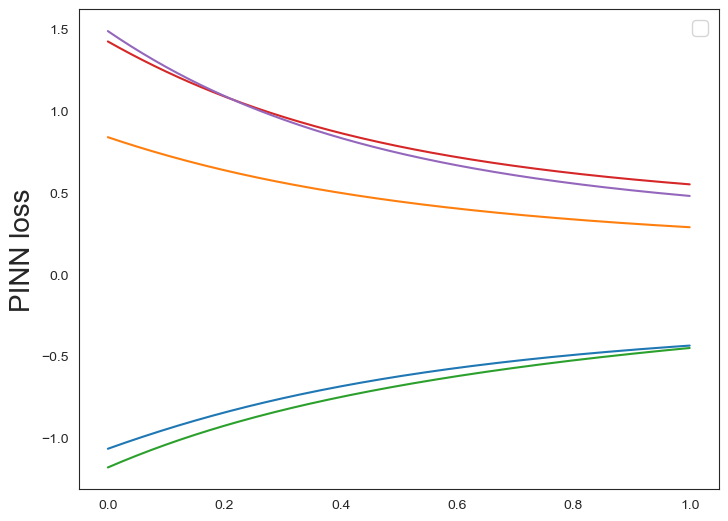

In [35]:
i = 0

fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

epoches_read = 100000

batch_size = 2046

h_train = 2/256

num_hidden = 2

num_hidden_R = 2
width_R = 8

result_matrix_reg = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    if num_divide != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/PINNs_withR/trained_model/1DBurgers-PINNs_withR-bs{batch_size}-epoches{epoches_read}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}-width{width}-hidden{num_hidden}-widthR{width_R}-hiddenR{num_hidden_R}-LBFGS{Adam_proportion}-{j}.pth"))


        # self.model.eval()
        # with torch.no_grad():
        v_pred, R = model(X_test)
            
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)
        # with torch.no_grad():
        #     v_pred, R = self.model(X)
        
        #     # boundary and initial point
        #     v_pred_bic, R_bic = self.model(X_bic)

        

        plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)])
        # plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)], label=f"width{width}, index{j}")

        # plt.xlabel('Width', size=20)
        plt.ylabel('PINN loss', size=20)
        # plt.title('min', size=20)
        
        # plt.ylim(0, 0.1)
        
            
        loss_vector = loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        # loss_vector = loss_fn(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        result_matrix_reg[i, j, :] = torch.tensor(loss_vector)

    i += 1


plt.legend(fontsize=15)


In [36]:
i = 0

result_matrix_new = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    if num_divide != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar(width, num_hidden, width_R_abs, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"./sidecar_new/trained_model/1DBurgers-abs4-noR{coe_without_R_new}-bs{batch_size}-epoches{epoches}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}-coe_structure{coe_structure}-coe_data{coe_data}-width{width}-hidden{num_hidden}-widthR{width_R_abs}-hidden_R{num_hidden_R}-LBFGS{Adam_proportion}-{j}.pth"))


        # self.model.eval()
        # with torch.no_grad():
        v_pred, R = model(X_test)
            
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)
        # with torch.no_grad():
        #     v_pred, R = self.model(X)
        
        #     # boundary and initial point
        #     v_pred_bic, R_bic = self.model(X_bic)

        fig=plt.figure(figsize=(8, 6))

        l, b, w, h = 0.1, 0.1, 0.8, 0.8

        ax1 = fig.add_axes([l, b, w, h])

        plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)], label=f"width{width}, index{j}")

        # plt.xlabel('Width', size=20)
        plt.ylabel('PINN loss', size=20)
        # plt.title('min', size=20)
        plt.legend(fontsize=15)
        
            
        loss_vector = loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        # loss_vector = loss_fn(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        result_matrix_new[i, j, :] = torch.tensor(loss_vector)

    i += 1





FileNotFoundError: [Errno 2] No such file or directory: './sidecar_new/trained_model/1DBurgers-abs4-noR0.0-bs2046-epoches10000-h_train0.0078125-tau_train0.01-gamma0.99999-coe_structure1e-05-coe_data1.0-width32-hidden2-widthR4-hidden_R2-LBFGS0.95-0.pth'

In [ ]:

results = result_matrix_new

# Extract the first component of the fourth dimension (index 0)
# first_component = results[..., 0]
first_component = results[..., 1] + results[..., 2]

# Calculate the minimum error for each parameter set and corresponding positions
min_errors_new = np.min(first_component, axis=1)
min_errors_positions = np.argmin(first_component, axis=1)

print(min_errors_new)

mean_errors_new = np.zeros([int(len(param_vector))])
mean_energy_errors_new = np.zeros([int(len(param_vector))])

median_errors_new = np.zeros([int(len(param_vector))])
median_energy_errors_new = np.zeros([int(len(param_vector))])
median_shock_errors_new = np.zeros([int(len(param_vector))])

for i in range(len(param_vector)):

    mean_errors_new[i] = geometric_mean(first_component[i,:]) # PDE
    mean_energy_errors_new[i] = geometric_mean(results[i,:,5]) # PDE

    median_errors_new[i] = np.median(first_component[i,:])
    median_energy_errors_new[i] = np.median(results[i,:,3])
    median_shock_errors_new[i] = np.median(results[i,:,-1])


print(mean_energy_errors_new)

# Find the global minimum error and its position
global_min_error_new = np.min(min_errors_new)
global_min_position = np.unravel_index(np.argmin(min_errors_new), min_errors_new.shape)
energy_min_error_new = results[np.arange(results.shape[0]), [min_errors_positions.astype(int)], 5]
shock_min_error_new = result_matrix_new[np.arange(result_matrix_new.shape[0]), [min_errors_positions.astype(int)], -1]
structure_min_error_new = results[np.arange(results.shape[0]), [min_errors_positions.astype(int)], 4]
exact_min_error_new = results[np.arange(results.shape[0]), [min_errors_positions.astype(int)], 3]

# Print the results
print(f"Global minimum error: {global_min_error_new}")
print(f"Parameter indices for global minimum error: {global_min_position}")
print(f"Repetition index for global minimum error: {min_errors_positions[global_min_position]}")

print(f"energy error: {results[np.arange(results.shape[0]), [min_errors_positions.astype(int)], 5]}")

[5.7439145e-08]
[5.35797934e-06]
Global minimum error: 5.743914499589664e-08
Parameter indices for global minimum error: (0,)
Repetition index for global minimum error: 5
energy error: [[9.67478011e-07]]


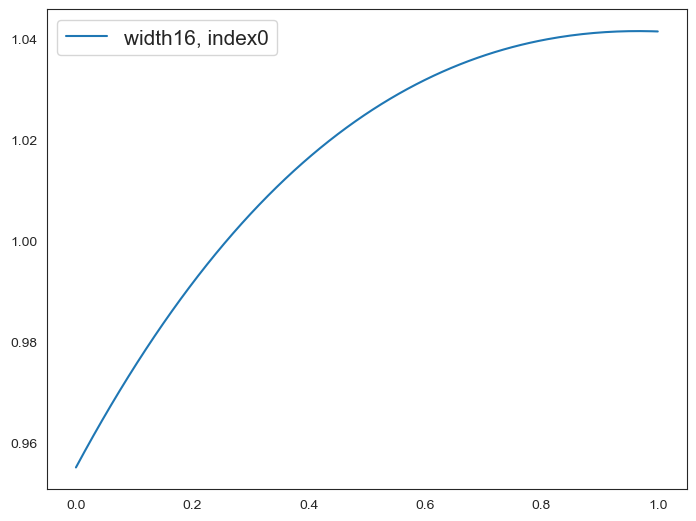

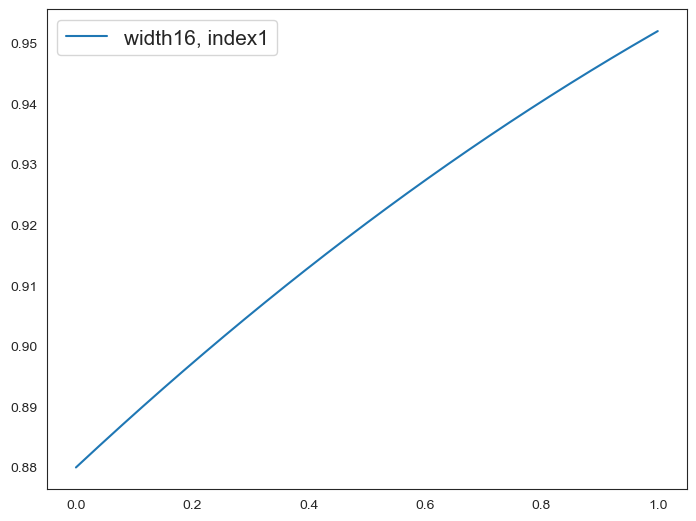

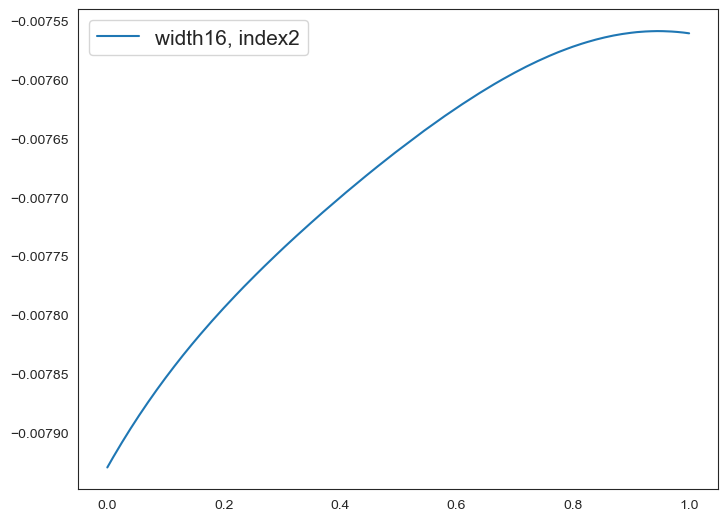

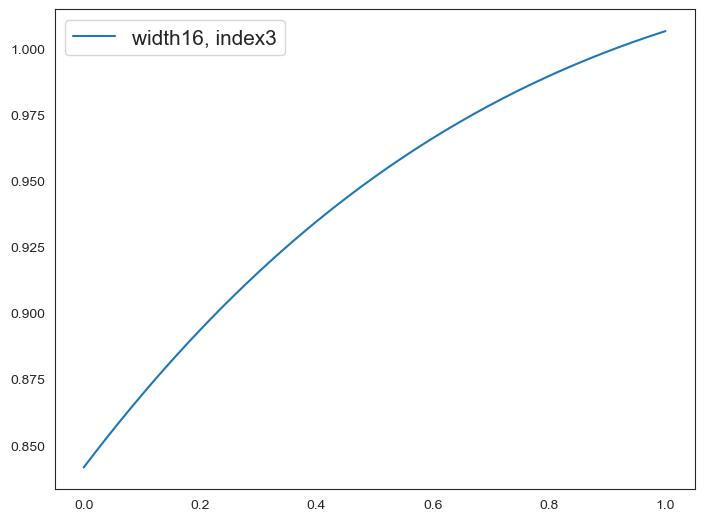

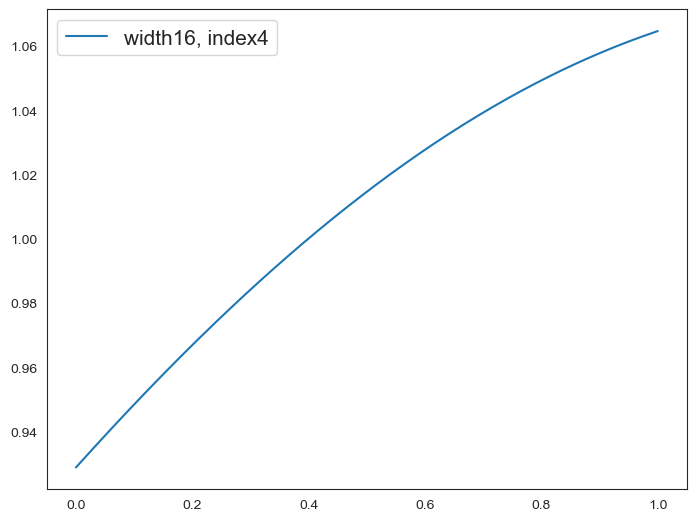

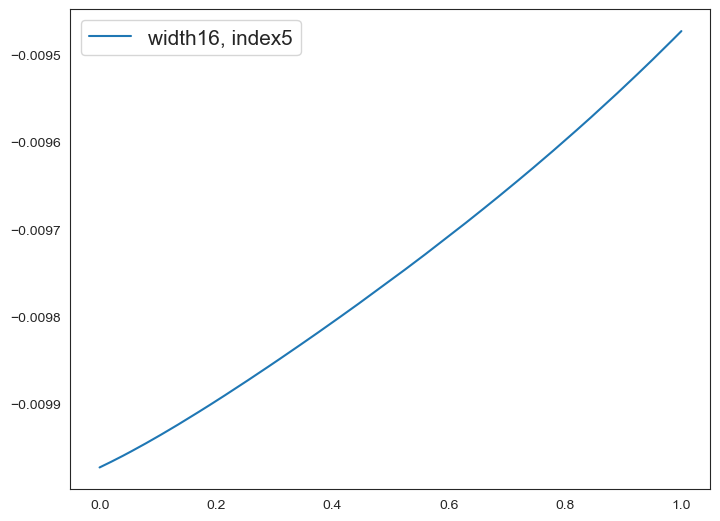

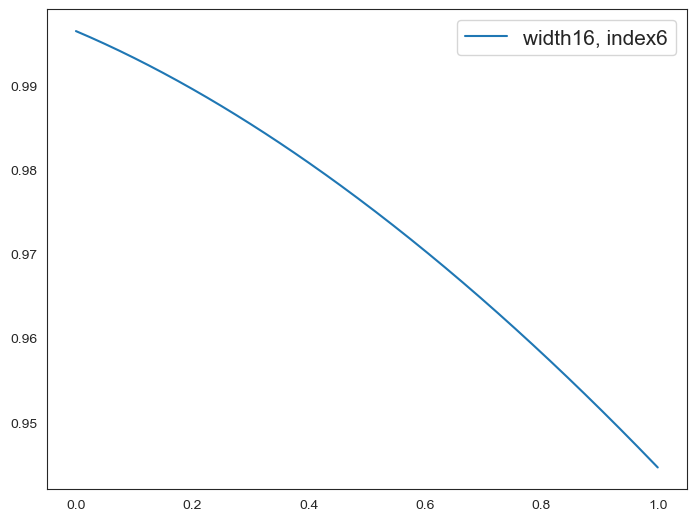

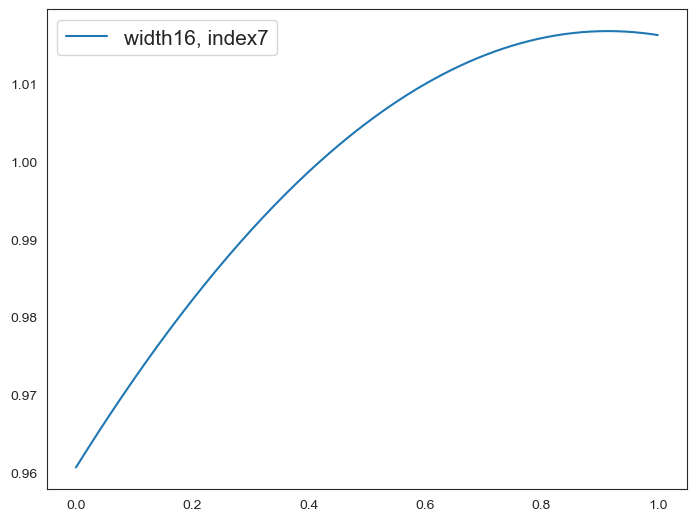

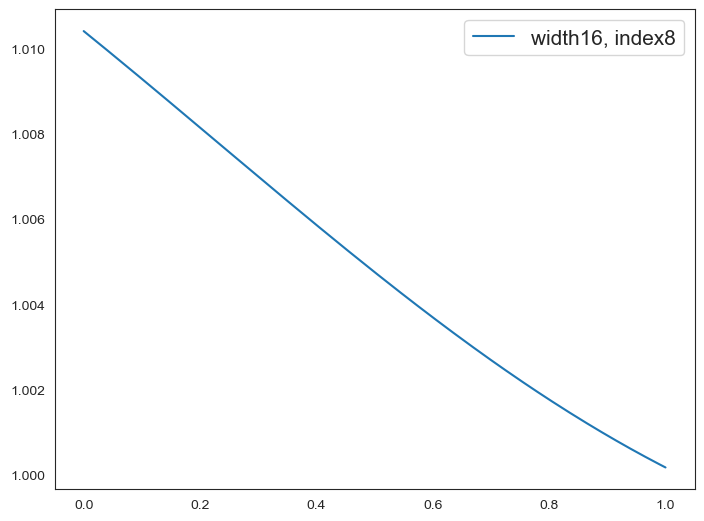

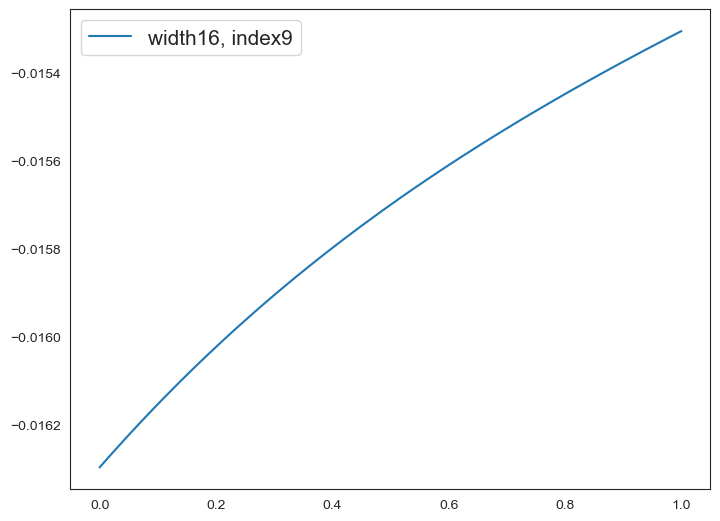

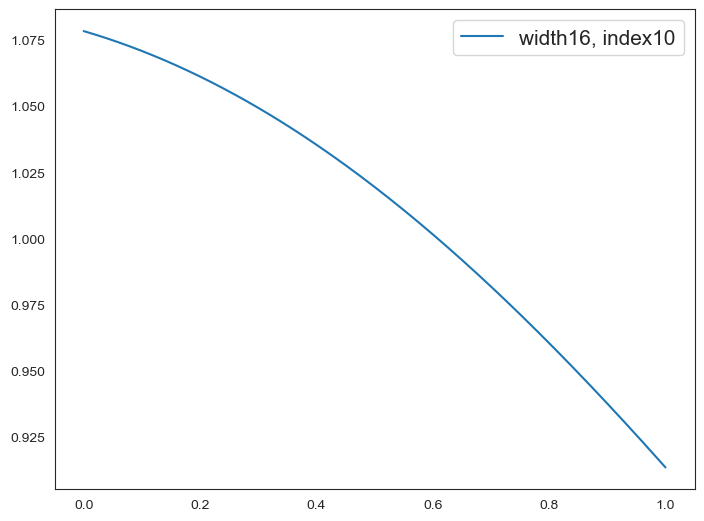

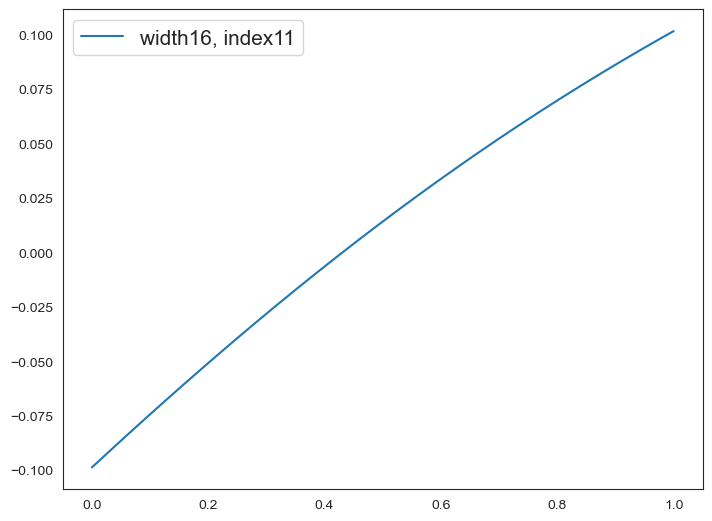

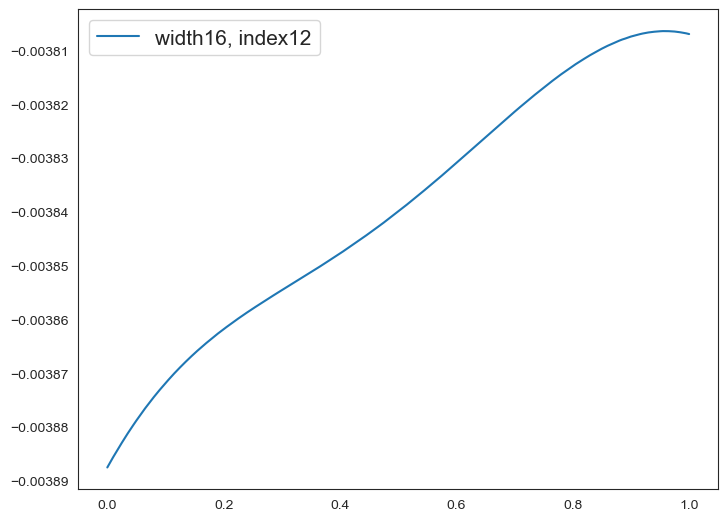

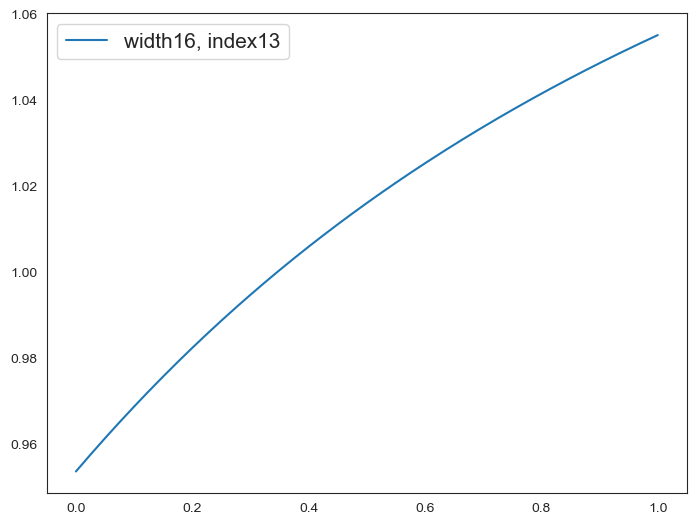

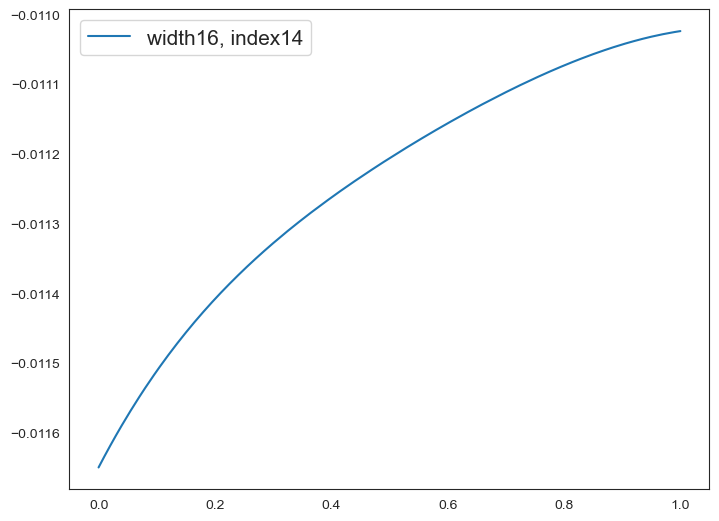

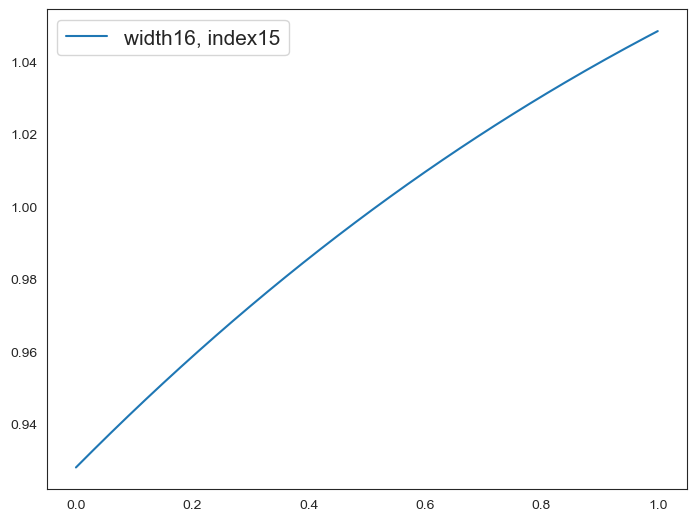

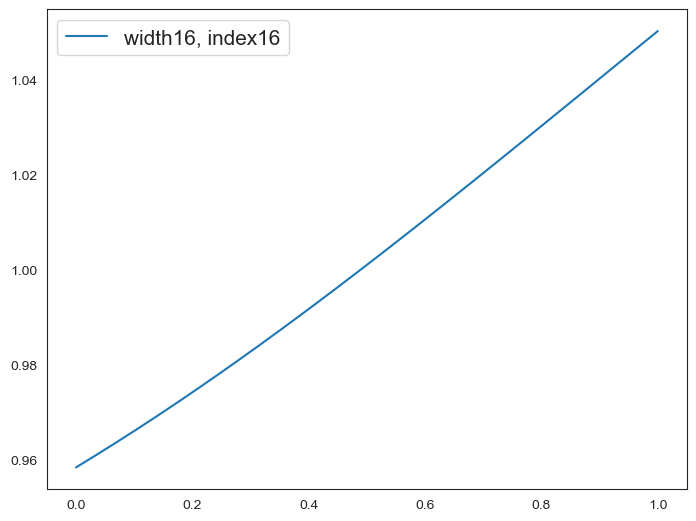

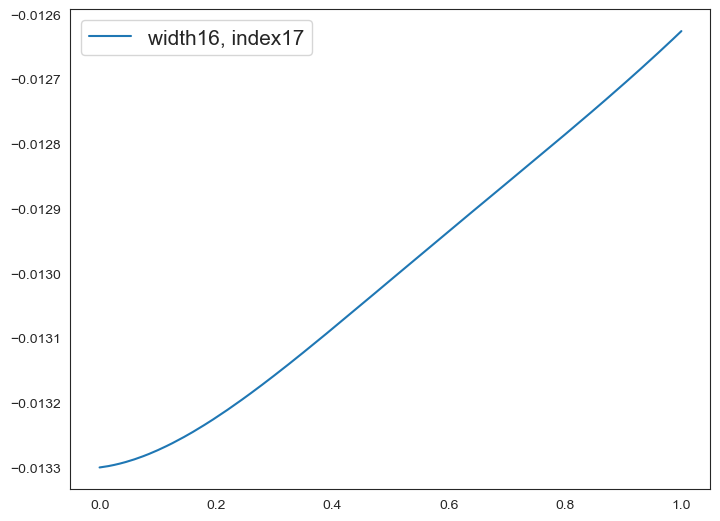

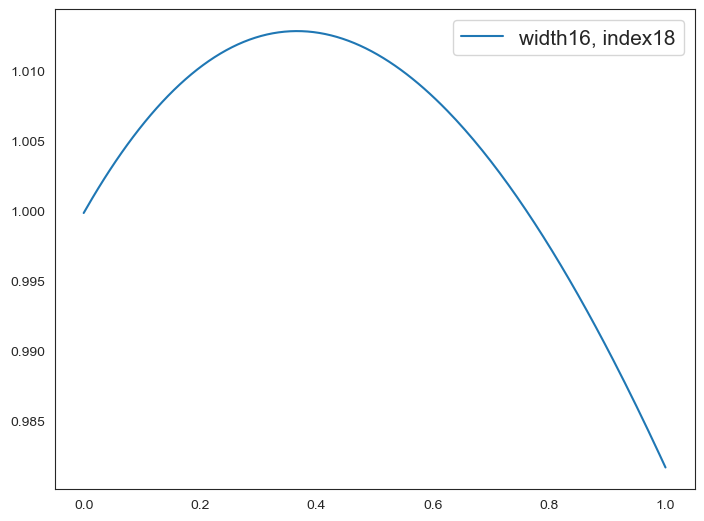

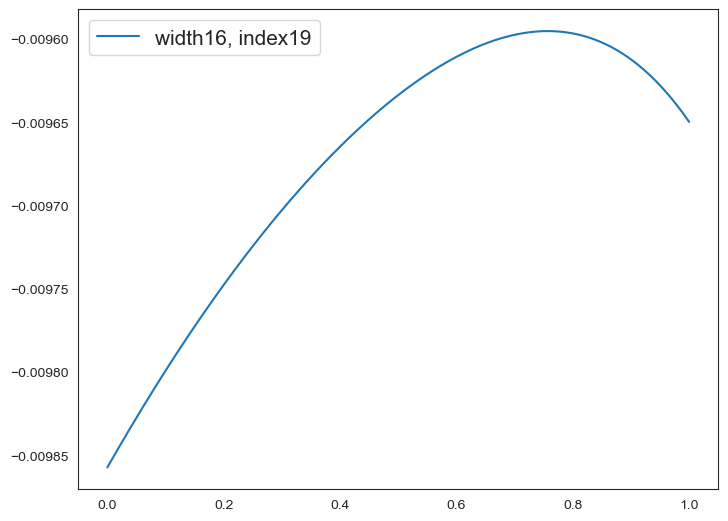

In [ ]:
i = 0

result_matrix_new = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    if num_divide != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar(width, num_hidden, width_R_reg, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"./sidecar_reg/trained_model/1DBurgers-abs4-noR{coe_without_R_reg}-bs{batch_size}-epoches{epoches}-h_train{h_train}-tau_train{tau_train}-gamma{gamma}-coe_structure{coe_structure}-coe_regular{coe_regular}-width{width}-hidden{num_hidden}-widthR{width_R_reg}-hidden_R{num_hidden_R}-LBFGS{Adam_proportion}-{j}.pth"))


        # self.model.eval()
        # with torch.no_grad():
        v_pred, R = model(X_test)
            
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)
        # with torch.no_grad():
        #     v_pred, R = self.model(X)
        
        #     # boundary and initial point
        #     v_pred_bic, R_bic = self.model(X_bic)

        fig=plt.figure(figsize=(8, 6))

        l, b, w, h = 0.1, 0.1, 0.8, 0.8

        ax1 = fig.add_axes([l, b, w, h])

        plt.plot(t_test.detach().cpu().numpy(), R.detach().cpu().numpy()[0:len(t_test)], label=f"width{width}, index{j}")

        # plt.xlabel('Width', size=20)
        # plt.ylabel('PINN loss', size=20)
        # plt.title('min', size=20)
        plt.legend(fontsize=15)
        
            
        loss_vector = loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        # loss_vector = loss_fn(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)

        result_matrix_new[i, j, :] = torch.tensor(loss_vector)

    i += 1





# plot

In [ ]:
from statistics import geometric_mean

from matplotlib.ticker import FixedLocator, NullFormatter, LogLocator, FixedFormatter, FuncFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = np.array(param_vector)


# total = np.zeros([3, int(len(x))])
# mean = np.zeros([3, int(len(x))])
# energy = np.zeros([3, int(len(x))])

# total[0, :] = min_errors_PINN
# total[1, :] = min_errors_direct
# total[2, :] = min_errors_sidecar

# mean[0, :] = mean_errors_PINN
# mean[1, :] = mean_errors_direct
# mean[2, :] = mean_errors_sidecar

# energy_min_error_PINN = np.squeeze(energy_min_error_PINN)
# energy_min_error_direct = np.squeeze(energy_min_error_direct)
# energy_min_error_sidecar = np.squeeze(energy_min_error_sidecar)
# energy_min_error_free = np.squeeze(energy_min_error_free)
# energy_min_error_direct
# energy_min_error_sidecar


# index = [2, 4, 8, 16, 32, 64, 128, 256]
index = param_vector 


[ True]


NameError: name 'min_errors_PINNs_LBFGS' is not defined

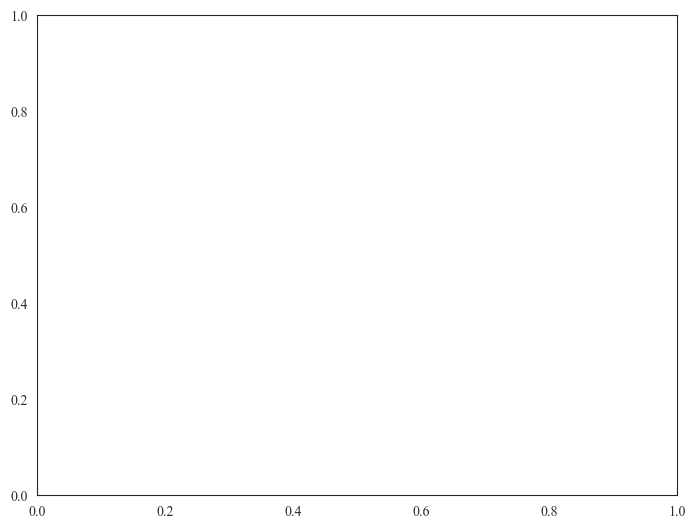

In [ ]:
fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

print(np.isin(x, index))
# print(x[index])

# plt.plot(x[np.isin(x, index)], min_errors_PINN[np.isin(x, index)], label='PINNs')
plt.plot(x[np.isin(x, index)], min_errors_PINNs_LBFGS[np.isin(x, index)], label='PINN')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='strict')
# plt.plot(x[np.isin(x, index)], min_errors_free[np.isin(x, index)], label='Sidecar')
# plt.plot(x[np.isin(x, index)], min_errors_LBFGS[np.isin(x, index)], label='LBFGS')
# plt.plot(x[np.isin(x, index)], min_errors_abs[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], min_errors_new[np.isin(x, index)], label='Sidecar')
# plt.plot(x[np.isin(x, index)], min_errors_abs2[np.isin(x, index)], label='abs2')
# 
plt.xlabel('Width', size=20)
plt.ylabel('PINN loss', size=20)
# plt.title('min', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

ax1.set_ylim(1e-8, 1e-6)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(c)', size=30)



plt.savefig('plot_LBFGS_pde.pdf', bbox_inches='tight')
plt.show()





fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

# index = [2, 4, 8, 16, 32]

print(np.isin(x, index))
# print(x[index])


# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_PINN)[np.isin(x, index)], label='PINNs')
plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_PINNs_LBFGS)[np.isin(x, index)], label='PINN')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_free)[np.isin(x, index)], label='Sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_LBFGS)[np.isin(x, index)], label='LBFGS')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_abs)[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_new)[np.isin(x, index)], label='Sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_abs2)[np.isin(x, index)], label='abs2')

# plt.errorbar(x2, mean2, yerr=yerr2, capsize = 3, label='adj = 10, MSE error')
# plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Random')
# plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order')
# plt.yscale('log')
# plt.ylim((1e-9,1))
# plt.xscale('log')
plt.xlabel('Width', size=20)
plt.ylabel('Energy error', size=20)
plt.legend(fontsize=15)
# plt.title('min', size=20)
# ax1.set_xticks(index)
# plt.xticks(x, x, fontsize=15)
# plt.xticks(fontsize=15)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

ax1.set_ylim(1e-7, 1e-5)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(d)', size=30)




plt.savefig('plot_LBFGS_energy.pdf', bbox_inches='tight')
plt.show()


fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

# index = [2, 4, 8, 16, 32]

print(np.isin(x, index))




# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_PINN)[np.isin(x, index)], label='PINNs')
plt.plot(x[np.isin(x, index)], np.squeeze(exact_min_error_PINNs_LBFGS)[np.isin(x, index)], label='PINN')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_direct)[np.isin(x, index)], label='direct')
# plt.plot(x[np.isin(x, index)], energy_min_error_sidecar[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_free)[np.isin(x, index)], label='free')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_LBFGS)[np.isin(x, index)], label='LBFGS')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_abs)[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], np.squeeze(exact_min_error_new)[np.isin(x, index)], label='Sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_abs2)[np.isin(x, index)], label='abs2')

plt.xlabel('Width', size=20)
plt.ylabel('Exact error', size=20)
# plt.title('min', size=20)
plt.legend(fontsize=15)
# ax1.set_xticks(index)
# plt.xticks(x, x, fontsize=15)
# plt.xticks(fontsize=15)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

ax1.set_ylim(1e-8, 1e-5)

# y_major_locator = LogLocator(base=10.0, numticks=20)
# y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
# ax1.yaxis.set_major_locator(y_major_locator)
# ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(d)', size=30)




plt.savefig('plot_position.pdf', bbox_inches='tight')
plt.show()



In [ ]:
fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

# index = [2, 4, 8, 16, 32]

print(np.isin(x, index))
# print(x[index])

plt.plot(x[np.isin(x, index)], median_errors_PINNs_LBFGS[np.isin(x, index)], label='PINNs_LBFGS')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='strict')
plt.plot(x[np.isin(x, index)], median_errors_abs[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], median_errors_new[np.isin(x, index)], label='new')

plt.xlabel('Width', size=20)
plt.ylabel('PINN Loss', size=20)
plt.title('median', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

# ax1.set_ylim(9e-7, 1.5e-6)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(c)', size=30)



plt.savefig('plot_LBFGS_pde.pdf', bbox_inches='tight')
plt.show()





fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

print(np.isin(x, index))

plt.plot(x[np.isin(x, index)], np.squeeze(median_energy_errors_PINNs_LBFGS)[np.isin(x, index)], label='PINNs_LBFGS')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_direct)[np.isin(x, index)], label='direct')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_sidecar)[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_sidecar)[np.isin(x, index)], label='strict')
plt.plot(x[np.isin(x, index)], np.squeeze(median_energy_errors_abs)[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], np.squeeze(median_energy_errors_new)[np.isin(x, index)], label='new')

plt.xlabel('Width', size=20)
plt.ylabel('Energy error', size=20)
plt.legend(fontsize=15)
plt.title('median', size=20)
# ax1.set_xticks(index)
# plt.xticks(x, x, fontsize=15)
# plt.xticks(fontsize=15)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

# ax1.set_ylim(3e-6, 1e-5)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(d)', size=30)




plt.savefig('plot_LBFGS_energy.pdf', bbox_inches='tight')
plt.show()


fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

# index = [2, 4, 8, 16, 32]

print(np.isin(x, index))


plt.plot(x[np.isin(x, index)], np.squeeze(median_shock_errors_PINNs_LBFGS)[np.isin(x, index)], label='PINNs_LBFGS')
# plt.plot(x[np.isin(x, index)], np.squeeze(shock_min_error_direct)[np.isin(x, index)], label='direct')
# plt.plot(x[np.isin(x, index)], energy_min_error_sidecar[np.isin(x, index)], label='sidecar')
plt.plot(x[np.isin(x, index)], np.squeeze(median_shock_errors_abs)[np.isin(x, index)], label='abs')
plt.plot(x[np.isin(x, index)], np.squeeze(median_shock_errors_new)[np.isin(x, index)], label='new')


plt.xlabel('Width', size=20)
plt.ylabel('Shockwave position error', size=20)
plt.title('median', size=20)
plt.legend(fontsize=15)
# ax1.set_xticks(index)
# plt.xticks(x, x, fontsize=15)
# plt.xticks(fontsize=15)

ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

# ax1.set_ylim(-1e-2, 6e-2)

# y_major_locator = LogLocator(base=10.0, numticks=20)
# y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
# ax1.yaxis.set_major_locator(y_major_locator)
# ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(d)', size=30)




plt.savefig('plot_position.pdf', bbox_inches='tight')
plt.show()



In [ ]:
fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

# index = [2, 4, 8, 16, 32]

print(np.isin(x, index))
# print(x[index])

plt.plot(x[np.isin(x, index)], mean_errors_PINNs_LBFGS[np.isin(x, index)], label='PINNs_LBFGS')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], min_errors_sidecar[np.isin(x, index)], label='strict')
plt.plot(x[np.isin(x, index)], mean_errors_abs[np.isin(x, index)], label='abs')

plt.xlabel('Width', size=20)
plt.ylabel('PINN Loss', size=20)
plt.title('mean', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

# ax1.set_ylim(9e-7, 1.5e-6)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(c)', size=30)



plt.savefig('plot_LBFGS_pde.pdf', bbox_inches='tight')
plt.show()





fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])

print(np.isin(x, index))

plt.plot(x[np.isin(x, index)], np.squeeze(mean_energy_errors_PINNs_LBFGS)[np.isin(x, index)], label='PINNs_LBFGS')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_direct)[np.isin(x, index)], label='direct')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_sidecar)[np.isin(x, index)], label='sidecar')
# plt.plot(x[np.isin(x, index)], np.squeeze(energy_min_error_sidecar)[np.isin(x, index)], label='strict')
plt.plot(x[np.isin(x, index)], np.squeeze(mean_energy_errors_abs)[np.isin(x, index)], label='abs')

plt.xlabel('Width', size=20)
plt.ylabel('Energy error', size=20)
plt.legend(fontsize=15)
plt.title('mean', size=20)
# ax1.set_xticks(index)
# plt.xticks(x, x, fontsize=15)
# plt.xticks(fontsize=15)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.tick_params(axis='x', which='major', labelsize=15)
ax1.xaxis.set_major_locator(FixedLocator(index))
ax1.xaxis.set_major_formatter(FixedFormatter(index))
ax1.xaxis.set_minor_formatter(NullFormatter())

# ax1.set_ylim(3e-6, 1e-5)

y_major_locator = LogLocator(base=10.0, numticks=20)
y_minor_locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=100)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax1.tick_params(axis='y', which='major', labelsize=15)
# plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X - .105, Y - 0.05, '(d)', size=30)




plt.savefig('plot_LBFGS_energy.pdf', bbox_inches='tight')
plt.show()